## Imports


In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Memory management
import gc

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Read in Data 

First, we can list all the available data files. There are a total of 9 files: 1 main file for training (with target) 1 main file for testing (without the target), 1 example submission file, and 5 other files containing additional information about each loan. 

In [3]:
print('Importing data...')
app_train = pd.read_csv('input/application_train.csv')
app_test = pd.read_csv('input/application_test.csv')
prev = pd.read_csv('input/previous_application.csv')
bureau = pd.read_csv('input/bureau.csv')
bureau_balance = pd.read_csv('input/bureau_balance.csv')
credit_card  = pd.read_csv('input/credit_card_balance.csv')
POS_CASH  = pd.read_csv('input/POS_CASH_balance.csv')
payments = pd.read_csv('input/installments_payments.csv')
print('Data import complete.')

Importing data...


FileNotFoundError: File b'input/application_train.csv' does not exist

In [ ]:
# Separate target variable
train_labels = app_train['TARGET']
del app_train['TARGET']

In [ ]:
print('Training data shape: ', app_train.shape)
print('Testing data shape: ', app_test.shape)

### Feature engineering

In [ ]:
# Add in the new features to the training dataframe
app_train['CREDIT_INCOME_PERCENT'] = app_train['AMT_CREDIT'] / app_train['AMT_INCOME_TOTAL']
app_train['ANNUITY_INCOME_PERCENT'] = app_train['AMT_ANNUITY'] / app_train['AMT_INCOME_TOTAL']
app_train['CREDIT_TERM'] = app_train['AMT_ANNUITY'] / app_train['AMT_CREDIT']
app_train['DAYS_EMPLOYED_PERCENT'] = app_train['DAYS_EMPLOYED'] / app_train['DAYS_BIRTH']

# Add in the new features to the testing dataframe
app_test['CREDIT_INCOME_PERCENT'] = app_test['AMT_CREDIT'] / app_test['AMT_INCOME_TOTAL']
app_test['ANNUITY_INCOME_PERCENT'] = app_test['AMT_ANNUITY'] / app_test['AMT_INCOME_TOTAL']
app_test['CREDIT_TERM'] = app_test['AMT_ANNUITY'] / app_test['AMT_CREDIT']
app_test['DAYS_EMPLOYED_PERCENT'] = app_test['DAYS_EMPLOYED'] / app_test['DAYS_BIRTH']


### Label Encoding and One-Hot Encoding

In [ ]:
#One-hot encoding of categorical features in data and test sets
categorical_features = [col for col in app_train.columns if app_train[col].dtype == 'object']

ohe_df = pd.concat([app_train, app_test])
ohe_df = pd.get_dummies(ohe_df, columns=categorical_features)

app_train = ohe_df.iloc[:app_train.shape[0],:]
app_test = ohe_df.iloc[app_train.shape[0]:,]

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

### Pre-process all data

In [ ]:
# Pre-process bureau_balance
bureau_grouped_size = bureau_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].size()
bureau_grouped_max = bureau_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].max()
bureau_grouped_min = bureau_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].min()

bureau_counts = bureau_balance.groupby('SK_ID_BUREAU')['STATUS'].value_counts(normalize = False)
bureau_counts_unstacked = bureau_counts.unstack('STATUS')
bureau_counts_unstacked.columns = ['STATUS_0', 'STATUS_1','STATUS_2','STATUS_3','STATUS_4','STATUS_5','STATUS_C','STATUS_X',]
bureau_counts_unstacked['MONTHS_COUNT'] = bureau_grouped_size
bureau_counts_unstacked['MONTHS_MIN'] = bureau_grouped_min
bureau_counts_unstacked['MONTHS_MAX'] = bureau_grouped_max

bureau = bureau.join(bureau_counts_unstacked, how='left', on='SK_ID_BUREAU')
print('bureau_balance pre-processing complete')

# Pre-process previous_application
#One-hot encoding of categorical features in previous application data set
prev_cat_features = [pcol for pcol in prev.columns if prev[pcol].dtype == 'object']
prev = pd.get_dummies(prev, columns=prev_cat_features)
avg_prev = prev.groupby('SK_ID_CURR').mean()
cnt_prev = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
avg_prev['nb_app'] = cnt_prev['SK_ID_PREV']
del avg_prev['SK_ID_PREV']
print('previous_application pre-processing complete')

# Pre-process bureau
#One-hot encoding of categorical features in buro data set
bureau_cat_features = [bcol for bcol in bureau.columns if bureau[bcol].dtype == 'object']
bureau = pd.get_dummies(bureau, columns=bureau_cat_features)
avg_bureau = bureau.groupby('SK_ID_CURR').mean()
avg_bureau['bureau_count'] = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
del avg_bureau['SK_ID_BUREAU']
print('bureau pre-processing complete')

# Pre-process POS_CASH
le = LabelEncoder()
POS_CASH['NAME_CONTRACT_STATUS'] = le.fit_transform(POS_CASH['NAME_CONTRACT_STATUS'].astype(str))
nunique_status = POS_CASH[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').nunique()
nunique_status2 = POS_CASH[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').max()
POS_CASH['NUNIQUE_STATUS'] = nunique_status['NAME_CONTRACT_STATUS']
POS_CASH['NUNIQUE_STATUS2'] = nunique_status2['NAME_CONTRACT_STATUS']
POS_CASH.drop(['SK_ID_PREV', 'NAME_CONTRACT_STATUS'], axis=1, inplace=True)
print('POS_CASH pre-processing complete')

# Pre-process credit_card_balance
credit_card['NAME_CONTRACT_STATUS'] = le.fit_transform(credit_card['NAME_CONTRACT_STATUS'].astype(str))
nunique_status = credit_card[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').nunique()
nunique_status2 = credit_card[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').max()
credit_card['NUNIQUE_STATUS'] = nunique_status['NAME_CONTRACT_STATUS']
credit_card['NUNIQUE_STATUS2'] = nunique_status2['NAME_CONTRACT_STATUS']
credit_card.drop(['SK_ID_PREV', 'NAME_CONTRACT_STATUS'], axis=1, inplace=True)
print('credit_card_balance pre-processing complete')

# Pre-process installments_payments
avg_payments = payments.groupby('SK_ID_CURR').mean()
avg_payments2 = payments.groupby('SK_ID_CURR').max()
avg_payments3 = payments.groupby('SK_ID_CURR').min()
del avg_payments['SK_ID_PREV']
print('installments_payments pre-processing complete')

#### Join Databases

In [ ]:
print('Joining databases...')

app_train = app_train.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')

app_train = app_train.merge(right=avg_bureau.reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(right=avg_bureau.reset_index(), how='left', on='SK_ID_CURR')

app_train = app_train.merge(POS_CASH.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(POS_CASH.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')

app_train = app_train.merge(credit_card.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(credit_card.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')

app_train = app_train.merge(right=avg_payments.reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(right=avg_payments.reset_index(), how='left', on='SK_ID_CURR')

app_train = app_train.merge(right=avg_payments2.reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(right=avg_payments2.reset_index(), how='left', on='SK_ID_CURR')

app_train = app_train.merge(right=avg_payments3.reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(right=avg_payments3.reset_index(), how='left', on='SK_ID_CURR')

gc.enable()
gc.collect()

print('Joining complete')
print('Training data shape: ', app_train.shape)
print('Testing data shape: ', app_test.shape)

In [ ]:
app_train.head()

In [9]:
from sklearn.preprocessing import MinMaxScaler, Imputer
    
# Feature names
features = list(app_train.columns)

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(app_train)

# Transform both training and testing data
app_train = imputer.transform(app_train)
app_test = imputer.transform(app_test)

# Repeat with the scaler
scaler.fit(app_train)
app_train = scaler.transform(app_train)
app_test = scaler.transform(app_test)

gc.enable()
gc.collect()

print('Training data shape: ', app_train.shape)
print('Testing data shape: ', app_test.shape)

Training data shape:  (307511, 508)
Testing data shape:  (48744, 508)


In [10]:
from sklearn.model_selection import train_test_split

app_train, app_test, train_labels, test_labels = train_test_split(app_train, train_labels, test_size = 0.3, random_state = 200)
print("X Training shape", app_train.shape)
print("X Testing shape", app_test.shape)
print("Y Training shape", train_labels.shape)
print("Y Testing shape", test_labels.shape)

X Training shape (215257, 508)
X Testing shape (92254, 508)
Y Training shape (215257,)
Y Testing shape (92254,)


### Logistic Regression Implementation

In [11]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression() # default parameters

# Train on the training data
log_reg.fit(app_train, train_labels)

# Make predictions on the test data
logreg_pred = log_reg.predict_proba(app_test)[:, 1]

print("AUC Score",  roc_auc_score(test_labels, logreg_pred))

AUC Score 0.7609404236639349


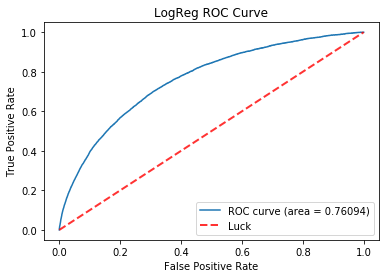

In [12]:
# Plot LogReg AUC curve
fpr, tpr, _ = roc_curve(test_labels, logreg_pred)
plt.plot(fpr,tpr,label='ROC curve (area = %0.5f)' % roc_auc_score(test_labels, logreg_pred))

# Plot the luck line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)

# Fine tune and show the plot
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LogReg ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Random Forest Implementation

In [31]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
#random_forest = RandomForestClassifier() # default parameters
random_forest = RandomForestClassifier(n_estimators = 400,
                                       max_depth = 5,
                                       min_samples_split = 2,
                                       min_samples_leaf = 50,
                                       min_weight_fraction_leaf = 0.0,
                                       n_jobs = -1,
                                       class_weight = 'balanced') # refined parameters

In [32]:
# Train on the training data
random_forest.fit(app_train, train_labels)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
random_forest_pred = random_forest.predict_proba(app_test)[:, 1]

print("AUC Score",  roc_auc_score(test_labels, random_forest_pred))

AUC Score 0.7234404414051021


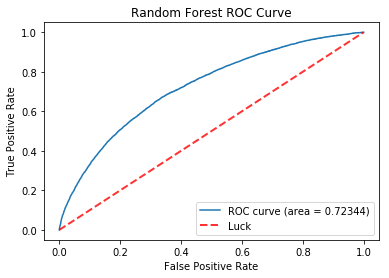

In [33]:
# Plot RandomForest AUC curve
fpr, tpr, _ = roc_curve(test_labels, random_forest_pred)
plt.plot(fpr,tpr,label='ROC curve (area = %0.5f)' % roc_auc_score(test_labels, random_forest_pred))

# Plot the luck line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)

# Show plot
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc="lower right")
plt.show()